Not Balanced Dataset

# Download dataset from kaggle

In [ ]:
from google.colab import files

! pip install -q kaggle
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d amanneo/diabetic-retinopathy-resized-arranged -p ./data/ --unzip

 99% 1.19G/1.21G [00:15<00:00, 74.1MB/s]
100% 1.21G/1.21G [00:15<00:00, 82.4MB/s]


# Make dataframe

In [ ]:
import os
import re
import pandas as pd

def define_paths(dir):
  files_path = []
  LR = []
  classes = []
  folders = os.listdir(dir)
  for folder in folders:
    folder_path = os.path.join(dir, folder)
    file_list = os.listdir(folder_path)
    for file_name in file_list:
      fpath = os.path.join(folder_path, file_name)
      regex_result = re.search(r"_(.*)\.", fpath)
      # append to the list
      files_path.append(fpath)
      LR.append(regex_result.group(1))
      classes.append(folder)
  return files_path, LR, classes

def define_df(files, LR, classes):
  file_series = pd.Series(files, name= 'file_paths')
  LR_series = pd.Series(LR, name='LR')
  class_series = pd.Series(classes, name='class')
  return pd.concat([file_series, LR_series, class_series,], axis= 1)

def make_df(dir):
  files, LR, classes = define_paths(dir)
  df = define_df(files, LR, classes)
  return df

In [ ]:
df = make_df('./data/')
df

,file_paths,LR,class
0,./data/1/869_left.jpeg,left,1
1,./data/1/9959_right.jpeg,right,1
2,./data/1/1540_right.jpeg,right,1
3,./data/1/6348_left.jpeg,left,1
4,./data/1/11421_right.jpeg,right,1
...,...,...,...
35121,./data/0/33100_left.jpeg,left,0
35122,./data/0/43904_right.jpeg,right,0
35123,./data/0/28607_left.jpeg,left,0
35124,./data/0/30329_left.jpeg,left,0


In [ ]:
print(df.groupby(['class', 'LR']).count())
print()
print(df.groupby(['LR']).count())

             file_paths
class LR               
0     left        12871
      right       12939
1     left         1212
      right        1231
2     left         2702
      right        2590
3     left          425
      right         448
4     left          353
      right         355

       file_paths  class
LR                      
left        17563  17563
right       17563  17563


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35126 entries, 0 to 35125
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_paths  35126 non-null  object
 1   LR          35126 non-null  object
 2   class       35126 non-null  object
dtypes: object(3)
memory usage: 823.4+ KB


In [ ]:
df.describe()

,file_paths,LR,class
count,35126,35126,35126
unique,35126,2,5
top,./data/1/869_left.jpeg,left,0
freq,1,17563,25810


# Exploratory Data Analysis (EDA)

In [ ]:
def plot(df, column):
  count = df[column].value_counts()
  percent = 100*df[column].value_counts(normalize=True)
  df = pd.DataFrame({'jumlah sampel':count, 'persentase':percent.round(1)})
  print(df)
  count.plot(kind='bar', title=column);

def plot_two_var(df, columns, divider):
  count = df.groupby(columns).file_paths.count().unstack(divider)
  print(count)
  count.plot.bar()

   jumlah sampel  persentase
0          25810        73.5
2           5292        15.1
1           2443         7.0
3            873         2.5
4            708         2.0


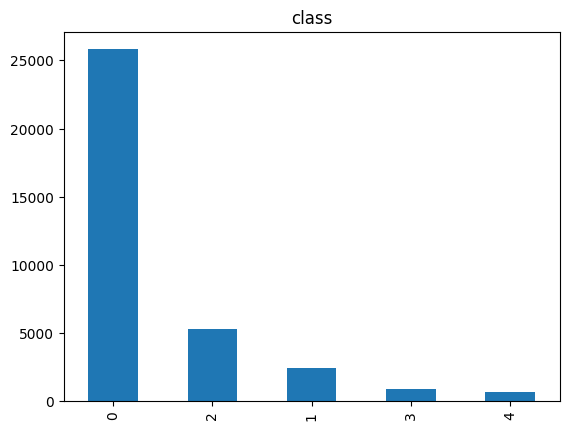

In [ ]:
plot(df, 'class')

LR      left  right
class              
0      12871  12939
1       1212   1231
2       2702   2590
3        425    448
4        353    355


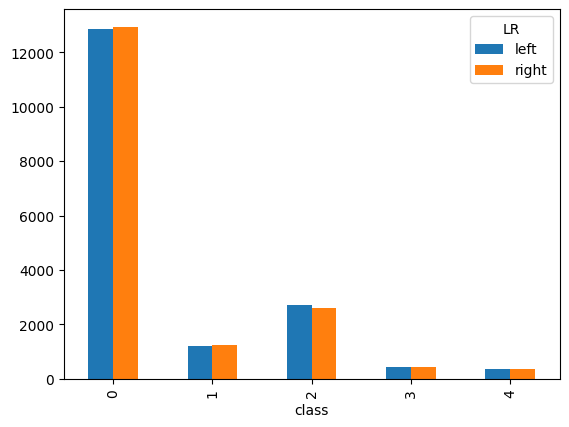

In [ ]:
plot_two_var(df, ['class', 'LR'], 'LR')

# Make to binary classification

In [ ]:
df['class'] = (df['class'].astype(int) >= 1).astype('string')

       jumlah sampel  persentase
False          25810        73.5
True            9316        26.5


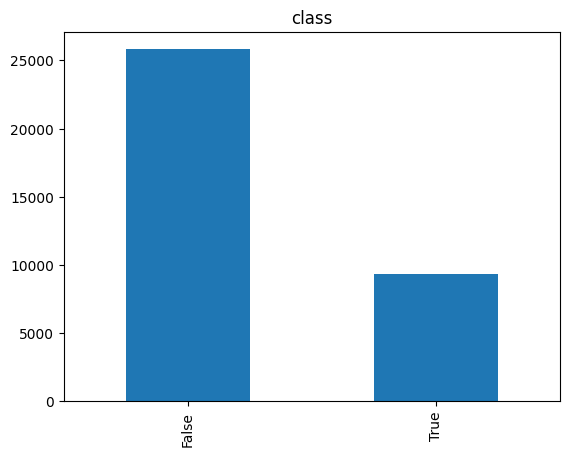

In [ ]:
plot(df, 'class')

In [ ]:
def take_n_sample_per_class(df, n, classes, random_state=42):
  new_df = pd.DataFrame()
  for i in classes:
    right_df = df.loc[(df['class'] == i)&(df['LR'] == 'right')].sample(n//2, random_state=random_state)
    left_df = df.loc[(df['class'] == i)&(df['LR'] == 'left')].sample(n//2, random_state=random_state)
    new_df = pd.concat([new_df, right_df, left_df])
  return new_df

def train_dev_test_split(df, train_rasio, dev_rasio, test_rasio):
  train_df = pd.DataFrame()
  dev_df = pd.DataFrame()
  test_df = pd.DataFrame()

  for i in df['class'].unique():
    right_df = df.loc[(df['class'] == i)&(df['LR'] == 'right')]
    left_df = df.loc[(df['class'] == i)&(df['LR'] == 'left')]
    train_len = int(len(right_df)*train_rasio)
    dev_len = int(len(right_df)*dev_rasio)
    test_len = int(len(right_df)*test_rasio)
    train_df = pd.concat([train_df, right_df[:train_len], left_df[:train_len]])
    dev_df = pd.concat([dev_df, right_df[train_len:train_len+dev_len], left_df[train_len:train_len+dev_len]])
    test_df = pd.concat([test_df, right_df[-test_len:], left_df[-test_len:]])
  return train_df, dev_df, test_df


# Split data

In [ ]:
train_df, dev_df, test_df = train_dev_test_split(df, 0.8, 0.1, 0.1)

In [ ]:
print('num of training set:', len(train_df))
print('num of dev set:', len(dev_df))
print('num of test set:', len(test_df))

num of training set: 28100
num of dev set: 3510
num of test set: 3510


       jumlah sampel  persentase
False          20702        73.7
True            7398        26.3


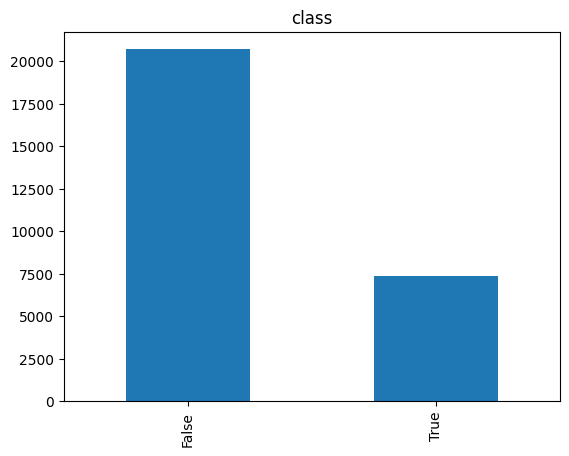

In [ ]:
plot(train_df, 'class')

# Reshuffle the dataset

In [ ]:
train_df = train_df.sample(frac=1, random_state=123).reset_index(drop=True)
dev_df = dev_df.sample(frac=1, random_state=123).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=123).reset_index(drop=True)

# Image Data Generator

In [ ]:
def preprocess_images(img):
    img = tf.image.adjust_contrast(img, 0.7)
    img = tf.image.adjust_brightness(img, 0.3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [224, 224])
    return img

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch = 128
ts_len = len(test_df)
test_batch = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len%n == 0 and ts_len/n <= 80]))

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 360,
    preprocessing_function = preprocess_images
    )

dev_test_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function = preprocess_images)

print('\nFor training')
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=True,
    seed=123,
    class_mode='binary')

print('\nFor dev')
dev_generator = dev_test_datagen.flow_from_dataframe(
    dev_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=batch,
    shuffle=False,
    class_mode='binary')

print('\nFor test')
test_generator = dev_test_datagen.flow_from_dataframe(
    test_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size=img_size,
    batch_size=test_batch,
    shuffle=False,
    class_mode='binary')


For training
Found 28100 validated image filenames belonging to 2 classes.

For dev
Found 3510 validated image filenames belonging to 2 classes.

For test
Found 3510 validated image filenames belonging to 2 classes.


# Modelling

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

def create_model(transfer_model, img_shape):
    if (transfer_model == "DenseNet201"):
      base_model = DenseNet201(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "Xception"):
      base_model = Xception(include_top= False, weights= "imagenet", input_shape= img_shape)
    elif (transfer_model == "MobileNetV2"):
      base_model = MobileNetV2(include_top= False, weights= "imagenet", input_shape= img_shape)
    else:
      base_model = VGG16(include_top= False, weights= "imagenet", input_shape= img_shape)

    base_model.trainable = False

    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dropout(0.5),
      Dense(128, activation= 'relu'),
      Dropout(0.3),
      Dense(64, activation= 'relu'),
      Dense(1, activation= 'sigmoid')
    ])

    return model

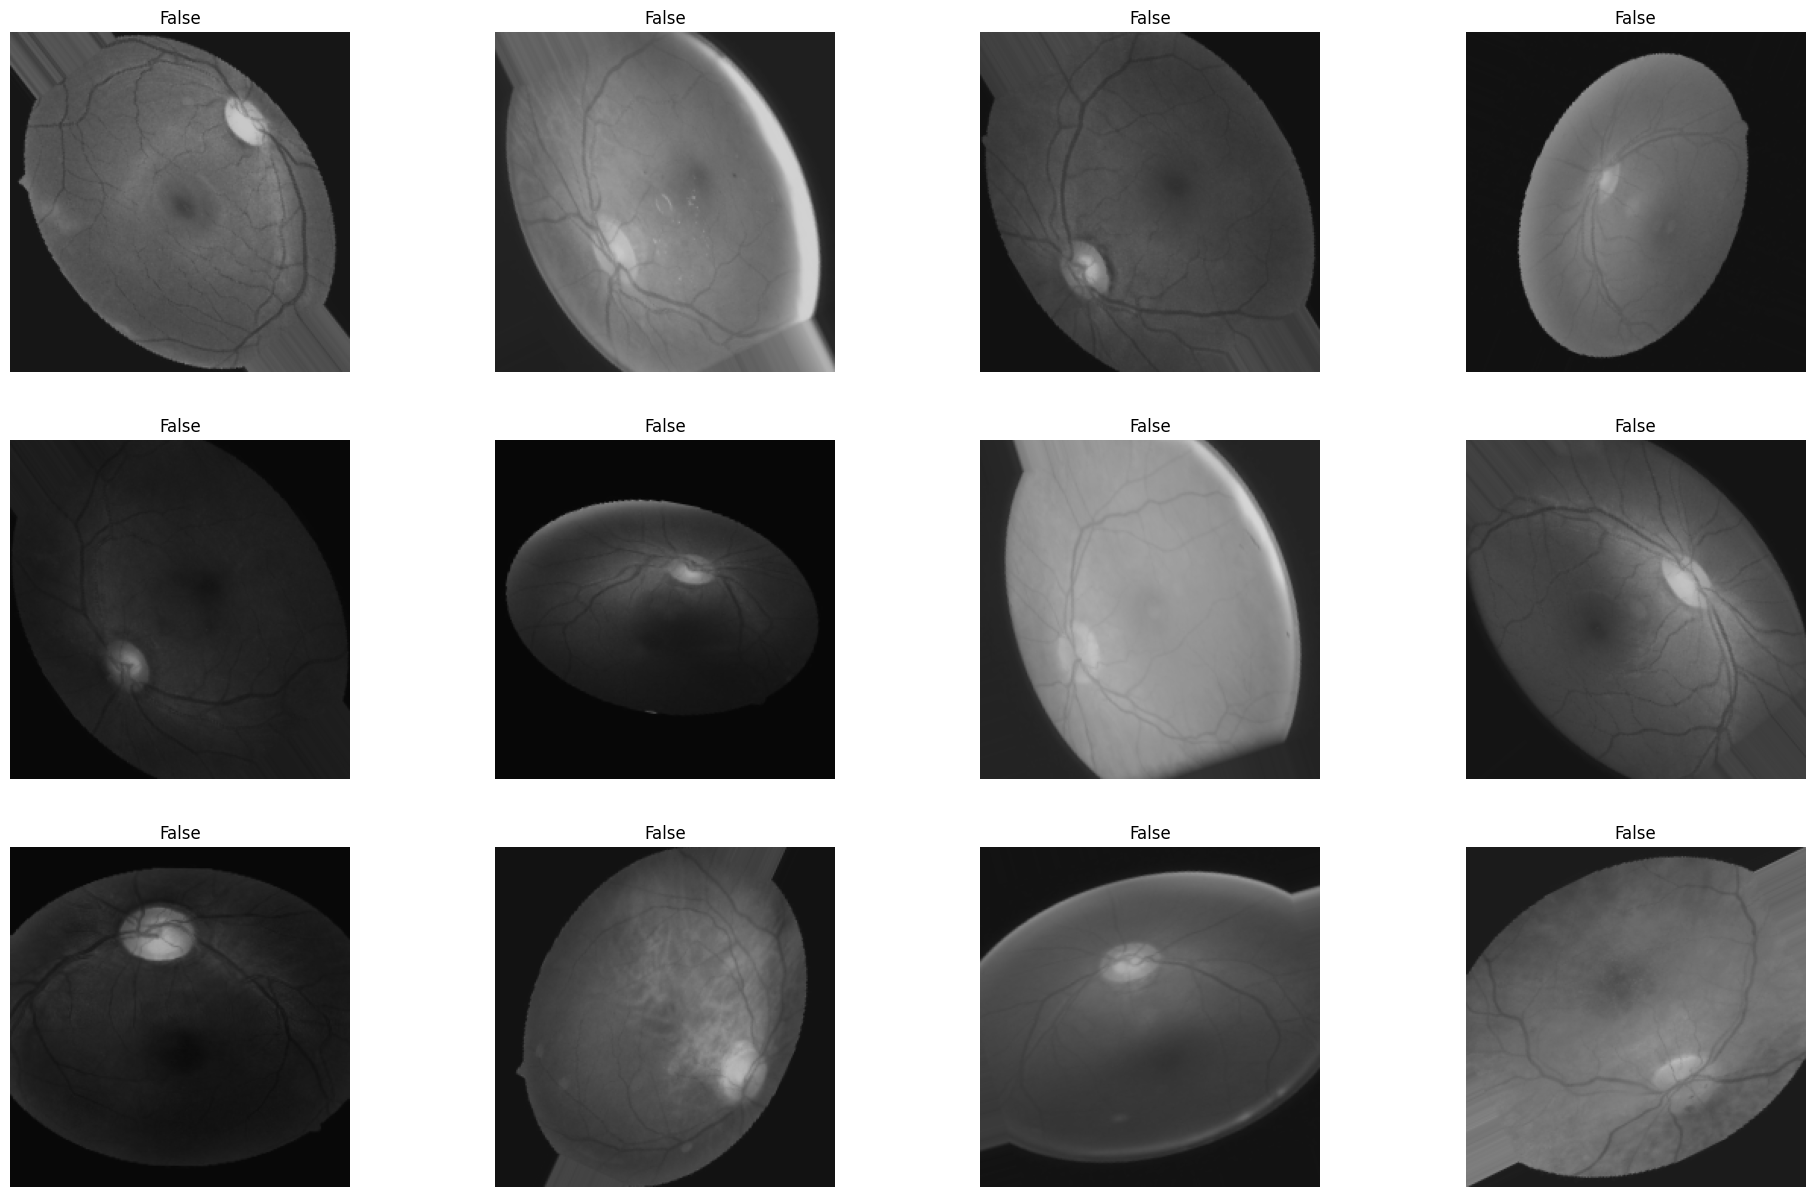

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# images after augmentation
def display_samples(generator, columns=4, rows=3):
    images, labels = next(generator)
    class_list = list(generator.class_indices.keys())
    fig = plt.figure(figsize=(6*columns, 5*rows))
    for i in range (columns*rows):
        fig.add_subplot(rows, columns, i+1)
        image = images[i]
        index = np.argmax(labels[i])
        class_name = class_list[index]
        plt.title(class_name)
        plt.imshow(image)
        plt.axis('off')

display_samples(train_generator)

In [ ]:
from keras.optimizers import Adam

model = create_model('MobileNetV2', (224, 224, 3))
model.compile(optimizer=Adam(), loss= 'binary_crossentropy', metrics= ['accuracy'])

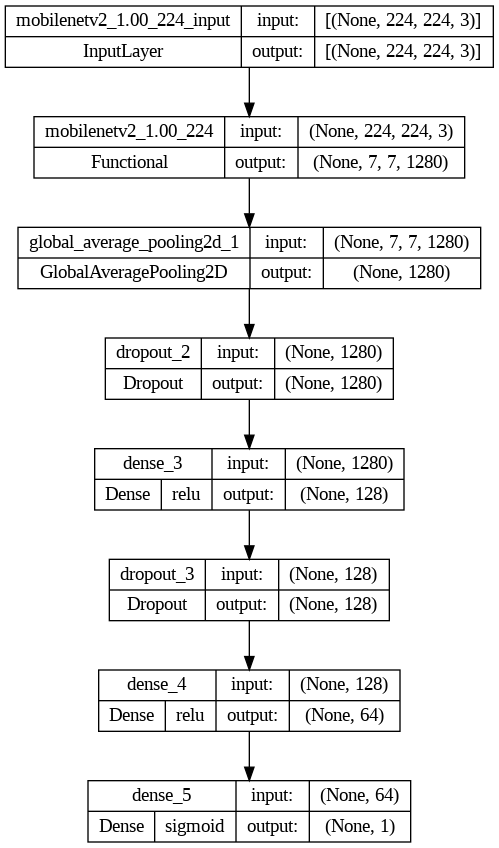

In [ ]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file,
                          show_shapes=True,
                          show_layer_activations=True,
                          show_layer_names=True )

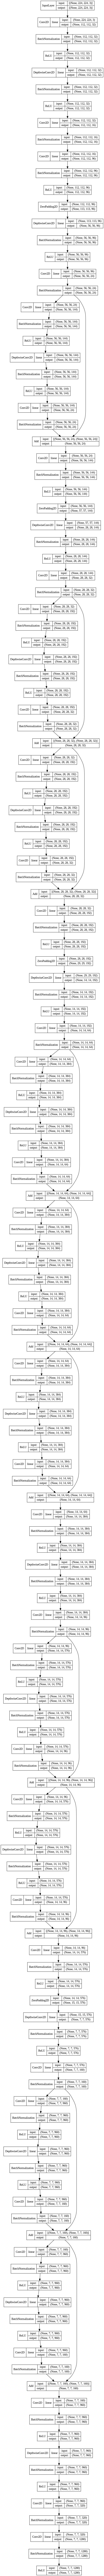

In [ ]:
base_model_img_file = 'base_model.png'
tf.keras.utils.plot_model(model.layers[0], to_file=base_model_img_file,
                          show_shapes=True,
                          show_layer_activations=True,
                          show_layer_names=False )

In [ ]:
epochs = 20
history = model.fit(
    x = train_generator,
    validation_data = dev_generator,
    epochs = epochs,
    verbose = 1,
)

Epoch 1/20
220/220 [==============================] - 716s 3s/step - loss: 0.5874 - accuracy: 0.7335 - val_loss: 0.5633 - val_accuracy: 0.7368
Epoch 2/20
220/220 [==============================] - 709s 3s/step - loss: 0.5773 - accuracy: 0.7364 - val_loss: 0.5645 - val_accuracy: 0.7368
Epoch 3/20
220/220 [==============================] - 715s 3s/step - loss: 0.5735 - accuracy: 0.7368 - val_loss: 0.5640 - val_accuracy: 0.7393
Epoch 4/20
220/220 [==============================] - 737s 3s/step - loss: 0.5719 - accuracy: 0.7366 - val_loss: 0.5441 - val_accuracy: 0.7368
Epoch 5/20
220/220 [==============================] - 711s 3s/step - loss: 0.5708 - accuracy: 0.7367 - val_loss: 0.5489 - val_accuracy: 0.7442
Epoch 6/20
220/220 [==============================] - 706s 3s/step - loss: 0.5701 - accuracy: 0.7368 - val_loss: 0.5536 - val_accuracy: 0.7373
Epoch 7/20
220/220 [==============================] - 734s 3s/step - loss: 0.5696 - accuracy: 0.7365 - val_loss: 0.5526 - val_accuracy: 0.7368

In [ ]:
model.save("model_mobilenet_dr.h5")

# Plot training

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]

    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

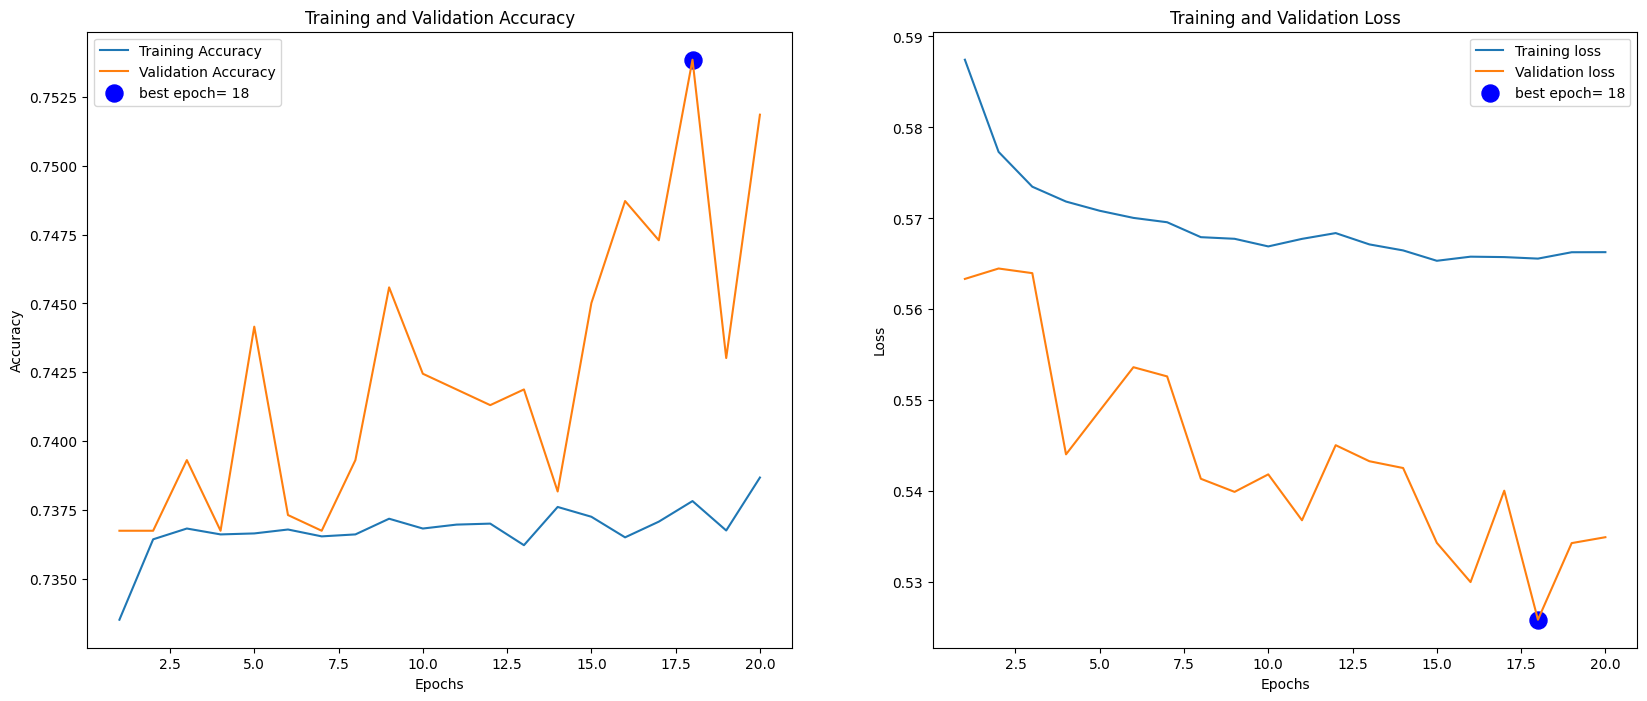

In [ ]:
plot_training(history)

# Fine Tuning

In [ ]:
# model.layers[0].trainable = True
# model.summary()

# model.compile(
#     optimizer=Adam(1e-6),  # Low learning rate
#     loss='binary_crossentropy',
#     metrics=['accuracy'],
# )

In [ ]:
# fine_tune_epoch = 10

# total_epochs =  epochs + fine_tune_epoch

# history_model_fine = model.fit(x=train_generator,
#                               epochs=total_epochs,
#                               initial_epoch=history.epoch[-1],
#                               validation_data=dev_generator)

# Predict

In [ ]:
preds = model.predict(test_generator)
y_pred = [np.argmax(y) for y in preds]
print(y_pred)

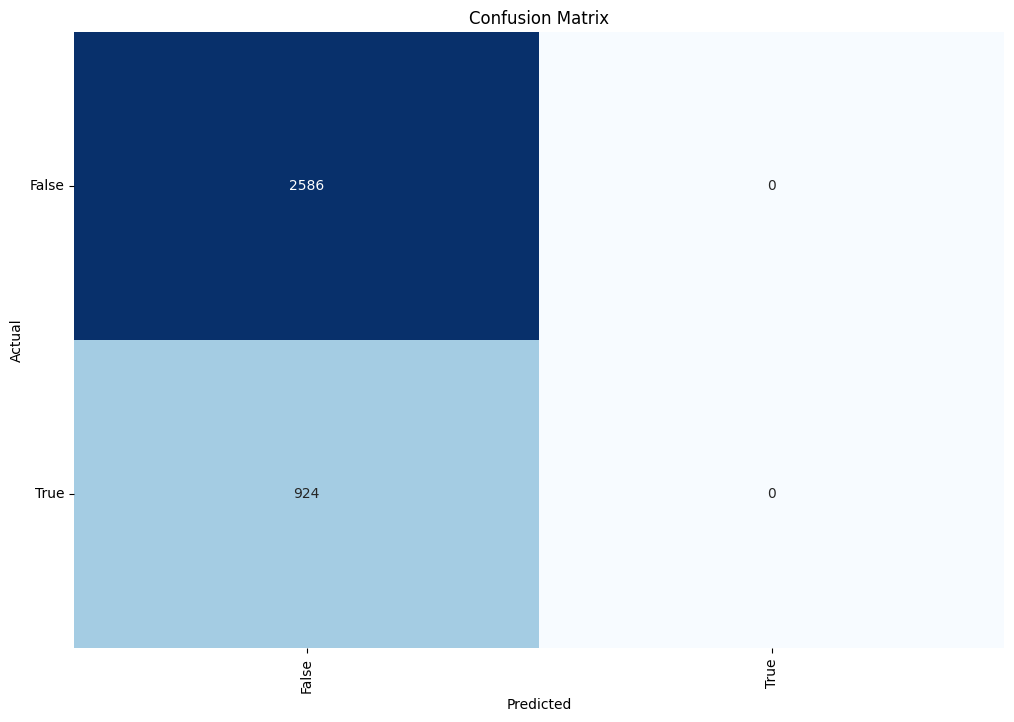


Classification Report:
----------------------
              precision    recall  f1-score   support

       False       0.74      1.00      0.85      2586
        True       0.00      0.00      0.00       924

    accuracy                           0.74      3510
   macro avg       0.37      0.50      0.42      3510
weighted avg       0.54      0.74      0.63      3510



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


def make_evaluation(test_gen, y_pred):
  classes = [label[:] for label in list(test_gen.class_indices.keys())]
  class_count = len(classes)
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(12, 8))
  sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
  plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
  plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()
  print("\nClassification Report:\n----------------------")
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

make_evaluation(test_generator, y_pred)

# Save Model

In [ ]:
# model.save("fine_tune_model_mobilenet_dr.h5")